# Exercise 3: Audio steganography

In [1]:
import numpy as np
import matplotlib.pyplot as plt

files = ["sounds/Ex3_sound1.wav", "sounds/Ex3_sound2.wav", "sounds/Ex3_sound3.wav", "sounds/Ex3_sound4.wav", "sounds/Ex3_sound5.wav"]

## Task 3.1: Audio analysis
Detects which audio file contains suspicious data in an ultrasonic range of frequencies and should be able to play the secret code in an audible range of frequencies. By filtering out ultrasonic frequencies, it was recognised that Ex3_sound1.wav had suspicious detected.

To get the secret code, the Least Significant Bits (LSBs) of the audio file's data frames are extracted. They are then grouped into 8-bit chunks that are converted into ASCII characters, extracted and processed until a sentinel character "#" is met.

By the output, Ex_sound1.wav has a hidden message: "Mom I will not be home for supper"

Suspicious signal detected in: sounds/Ex3_sound1.wav
demodulated audio saved as sounds/secret_code.wav


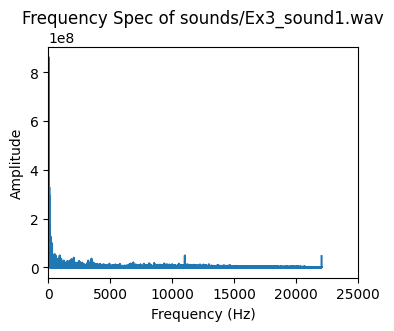

In [2]:
from scipy.io import wavfile
from scipy.signal import hilbert
from scipy.signal import butter, filtfilt
import soundfile as sf

def analyse(file):
    sr, data = wavfile.read(file);
    # using first channel if stereo
    if data.ndim > 1: data = data[:, 0]
    # print("Sampling rate:", sr)
    # print("Audio shape:", data)
    
    # perform FFT to display frequency content
    n = len(data)
    freqs = np.fft.rfftfreq(n, 1/sr)
    fft_magnitude = np.abs(np.fft.rfft(data))
    
    # plot frequency spectrum
    plt.figure(figsize = (4, 3))
    plt.plot(freqs, fft_magnitude)
    # focusing on frequencies up to 25 kHz
    plt.xlim(0, 25000)
    plt.title(f"Frequency Spec of {file}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    
    # finding ultrasonic frequencies (>20 kHz)
    ultrasonic_peaks = fft_magnitude[(freqs > 20000) & (freqs < 25000)]
    if np.max(ultrasonic_peaks) > np.mean(fft_magnitude) * 10:
        print(f"Suspicious signal detected in: {file}")
        return data, sr, freqs[np.argmax(ultrasonic_peaks) + np.argmax(freqs > 20000)]
    return None, None, None

# # adding a lowpass filter
# def lowpass(signal, sr, cutoff = 20000):
#     nyquist = sr / 2
#     b, a = butter(4, cutoff / nyquist, btype = "low")
#     return filtfilt(b, a, signal)

# demodulating the signal to tackle amplitude modulation
def demodulate(data, sr, carrier_freq):
    time = np.arange(len(data)) / sr
    # getting the carrier wave
    carrier = np.cos(2*np.pi * carrier_freq * time)
    # demodulate by multiplication
    modedSignal = data * carrier
    # getting the analytic signal
    demodedSignal = np.real(hilbert(modedSignal))
#     # applying lowpass filter
#     demodedSignal = lowpass(demodedSignal, sr)
    return demodedSignal

# save and play demodulated file
def saveAndPlay(data, sr, filename):
    # normalising data to [-1, 1]
    data = data / np.max(np.abs(data))
    sf.write(filename, data, sr)
    print(f"demodulated audio saved as {filename}")
    
for file in files:
    data, sr, carrier_freq = analyse(file)
    # if the file is suspicious, run decoding
    if data is not None:
        demodedSignal = demodulate(data, sr, carrier_freq)
        saveAndPlay(demodedSignal, sr, "sounds/secret_code.wav")
        break

In [3]:
import wave

def extractLSB(filename):
    # opening file in read only format
    with wave.open(filename, mode = "rb") as audio:
        # reads all frames of the file and stores it
        frameBytes = bytes(audio.readframes(audio.getnframes()))
    # extracts least significant bit of each byte
    return [frame_byte & 0x1 for frame_byte in frameBytes]

# converts every 8 bits to a character
def merge_8Bits_to_Char(bits8):
    # convert list of 8 bits to binary string - "0b" prefix
    binStr = "0b" + "".join(map(str, bits8))
    # use eval() to evaluate binary string and convert it to an integer
    # convert integer to its ASCII character
    return chr(eval(binStr))

# takes least significant bits and converts into characters
def LSB_Bytes_to_Chars(LSBBytes):
    chars = []
    # takes every group of 8 bits to convert into a character
    for bits8 in [LSBBytes[i: i+8] for i in range(0, len(LSBBytes), 8)]:
        currChar = merge_8Bits_to_Char(bits8)
        if currChar != '#': chars.append(currChar)
        # stops when it encounters "#", a sentinel character
        else: break
    return chars

def decodeFile(filename):
    # extracts LSBs of the file
    bytesExtracted = extractLSB(filename)
    # converts LSBs to characters
    charsExtracted = LSB_Bytes_to_Chars(bytesExtracted)    
    return "".join(charsExtracted)

# testing if it works
hiddenText = decodeFile("sounds/Ex3_sound1.wav")
print(f"The hidden message: {hiddenText}")

The hidden message: Mom I will not be home for supper


Suspicious signal detected in: sounds/Ex3_sound1.wav
demodulated audio saved as sounds/secret_code.wav
The hidden message: ÔÖþ³ø¹LZOiEGy{Ö¹ñ~Þv=ÝxÛ


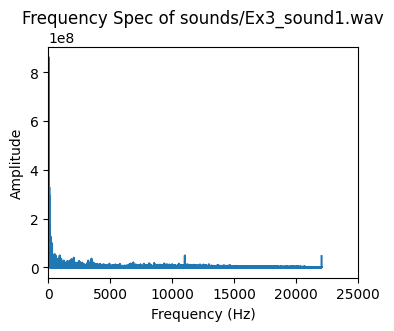

In [4]:
for file in files:
    data, sr, carrier_freq = analyse(file)
    # if the file is suspicious, run decoding
    if data is not None:
        demodedSignal = demodulate(data, sr, carrier_freq)
        saveAndPlay(demodedSignal, sr, "sounds/secret_code.wav")
        hiddenText = decodeFile("sounds/secret_code.wav")
        print(f"The hidden message: {hiddenText}")
        break

## Task 3.2: Embedding hidden messages


In [1]:
import wave
import random

def embedMessage(filename, outputFilename, message, num_lsb = 2, seed = 28):
    # opening audio file in read mode
    with wave.open(filename, "rb") as audio:
        # getting audio parameters
        params = audio.getparams()
        # converting audio frames into byte array
        frameBytes = bytearray(list(audio.readframes(audio.getnframes())))

    # converting message to binary
    message += "#"  # adding sentinel character to indicate the end
    ascii_vals = [ord(char) for char in message] # converting each char in msg to ASCII
    bin_strs = [f"{val:08b}" for val in ascii_vals] # converting each ASCII to 8-bit binStr
    message_bits = ''.join(bin_strs)

    # generating random position to embed message
    random.seed(seed)
    indices = random.sample(range(len(frameBytes)), len(message_bits))

    # embedding the message
    for i, bit in enumerate(message_bits):
        # embedding a bit of msg to LSBs
        # 1. calculate mask to clear LSBs
        mask = ~((1 << num_lsb) - 1)
        # 2. apply mask to clear LSBs of current byte
        cleared_byte = frameBytes[indices[i]] & mask
        # 3. convert curr bit to integer, place in LSB position (use bitwise OR)
        frameBytes[indices[i]] = (cleared_byte) | int(bit)

    # writing modified frames to output file
    with wave.open(outputFilename, "wb") as output:
        output.setparams(params)
        output.writeframes(bytes(frameBytes))

    print(f"Message embedded in {outputFilename}")

# testing the code
filename = "sounds/Ex3_sound5.wav"
outputFilename = "sounds/Ex3_sound5_stego.wav"
message = "An eye for an eye makes the whole world blind"

# embedding message
embedMessage(filename, outputFilename, message)

Message embedded in sounds/Ex3_sound5_stego.wav


In [2]:
def extractMsg(filename, num_lsb = 2, seed = 28):
    # opening audio file in read mode
    with wave.open(filename, "rb") as audio:
        # converting audio frames into byte array
        frameBytes = bytearray(list(audio.readframes(audio.getnframes())))

    # generating random position to extract message
    random.seed(seed)
    indices = random.sample(range(len(frameBytes)), len(frameBytes))

    # extracting message bits (similar to embedding)
    extracted_bits = [(frameBytes[i] & ((1 << num_lsb) - 1)) for i in indices]

    # grouping bits into bytes and decoding the message
    message = ""
    for i in range(0, len(extracted_bits), 8):
        byte = extracted_bits[i:i+8]
        char = chr(int(''.join(map(str, byte)), 2))
        if char == "#":  # Stop at the sentinel
            break
        message += char

    return message

# extracting message
extracted_message = extractMsg(outputFilename)
print(f"Extracted message: {extracted_message}")

Extracted message: An eye for an eye makes the whole world blind


## Task 3.3: Further investigation of SOTA audio steganographic approach